In [1]:
# add ..\ to path
import sys
sys.path.append('..\\')
from scripts.algo.iterative_phase_estimation import iterative_phase_estimation


In [2]:
import numpy as np
from qiskit_aer import Aer
U = np.array([[1, 0], [0, -1]])
eigenstate = np.array([1, 0])
num_evals = 100

# Run the algorithm. Determine how many times the control qubit was measured to be 0.

# Now, to exectue a qiksit circuit, qe need to specify a few things:
# 1. The backend: this is the simulator or the real quantum computer that will run the circuit
'''service = QiskitRuntimeService()
available_backends = service.backends()
filtered_backends = service.backends(available=True, min_num_qubits=2, simulator=True)
selected_backend = service.least_busy(filtered_backends)'''
# Since I dont have an account, I will use the Aer simulator
selected_backend = Aer.get_backend('qasm_simulator')

# 2. Experiment: this is the circuit that we want to run. It is a QuantumCircuit object
p_0, qc = iterative_phase_estimation(U, num_evals, eigenstate, selected_backend)
print(p_0)


1.0


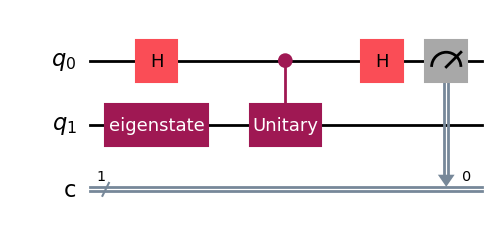

In [3]:
qc.draw('mpl')

In [4]:
# Sexier Hamiltonian: Hubbard model
from qiskit_nature.second_q.operators import FermionicOp

'''A FermionicOp represents a weighted sum of fermionic creation/annihilation operator terms. 
These terms are encoded as sparse labels, which are strings consisting of a space-separated 
list of expressions. Each expression must look like [+-]_<index>, where the <index> is a 
non-negative integer representing the index of the fermionic mode where the + (creation) 
or - (annihilation) operation is to be performed. The value of index is bound by the number of spin orbitals 
(num_spin_orbitals) of the operator '''

# Define the one-body interactions (kinetic term)
t = 1 # hopping term
one_body_interactions = FermionicOp({"+_0 -_1": -t, "+_1 -_0": -t})

# Define the two-body interactions (interaction term)
U = 1 # Coulomb repulsion
two_body_interactions = FermionicOp({"+_0 -_0 +_1 -_1": U})

# Define the Hubbard Hamiltonian
H = one_body_interactions + two_body_interactions
H

FermionicOp({'+_0 -_1': -1, '+_1 -_0': -1, '+_0 -_0 +_1 -_1': 1}, num_spin_orbitals=2, )

In [5]:
# Convert Fermionic hamiltonian to pauli operators using the Jordan-Wigner transformation
from qiskit_nature.second_q.mappers import JordanWignerMapper

mapper = JordanWignerMapper()

qubit_op = mapper.map(H)

qubit_op

SparsePauliOp(['YY', 'XX', 'II', 'ZI', 'IZ', 'ZZ'],
              coeffs=[-0.5 +0.j, -0.5 +0.j,  0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j])

In [6]:
# Run the Iterative Phase Estimation algorithm with the Hubbard Hamiltonian
import numpy as np
num_evals = 10
eigenstate = np.array([1, 0, 0, 0])
p_0, qc = iterative_phase_estimation(qubit_op, num_evals, eigenstate, selected_backend, num_qubits=2)
print(p_0)

ValueError: Input matrix is not unitary.

In [1]:
# New plan: Come up with a Hamiltonian that is easier to simulate.
# Try idk XX or something.
from qiskit.quantum_info import Operator, SparsePauliOp
from qiskit.circuit.library import UnitaryGate
import random
from qiskit_algorithms import NumPyEigensolver
import numpy as np

# rand_angle = random.randint(0, 100) % np.pi
z_rotation = np.array([[1, 0], [0, np.exp(1j*np.pi/4)]])
z_rotation = UnitaryGate(z_rotation)
exact_eigensolver = NumPyEigensolver()
exact_eigenvalue = exact_eigensolver.compute_eigenvalues(z_rotation)

eigenstate = np.array([0, 1]) # initial state
iterations = []
estimations = []

for i in range(1, 1000, 5):
    num_evals = i
    print(f'current number of evaluations: {num_evals}')
    p_0, qc = iterative_phase_estimation(z_rotation, num_evals, eigenstate, selected_backend, num_qubits=1)
    print(p_0)
    estimated_eigenvalue = 2 * np.arccos(np.sqrt(p_0))
    iterations.append(i)
    estimations.append(estimated_eigenvalue)
    print(f"estimation: {estimated_eigenvalue} \n exact answer: {exact_eigenvalue}")


NameError: name 'np' is not defined

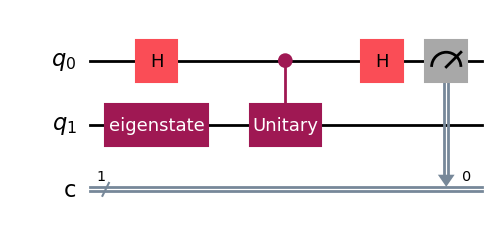

In [8]:
qc.draw('mpl')

In [13]:
estimations

[0.0,
 0.0,
 0.0,
 0.5053605102841571,
 0.43997595479091867,
 0.0,
 0.3611704283813961,
 0.47588224966041676,
 0.31363137068880176,
 0.5164751408468756,
 0.3986944154012026,
 0.0,
 0.4472511722587673,
 0.34993809133137727,
 0.0,
 0.22992184100141302,
 0.38731660088865383,
 0.21608570513150585,
 0.36516196935237544,
 0.2896869939971194,
 0.28237623523407457,
 0.2755924492917697,
 0.26927522322650016,
 0.2633734161168334,
 0.31623438081562744,
 0.17841068709508331,
 0.24775399117107916,
 0.34470117979864584,
 0.4493970068835401,
 0.37226237855355915,
 0.3269699442535191,
 0.3947911196997609,
 0.3543039591591929,
 0.1553863826761716,
 0.3768605010990881,
 0.3026652739544314,
 0.29842378703558614,
 0.3904675996048842,
 0.29044970929683867,
 0.28669513781073086,
 0.28308250902316695,
 0.3430071080048265,
 0.23904735176202815,
 0.30547666919464295,
 0.2698874721562527,
 0.3785444638157416,
 0.26394619840615907,
 0.3202633553698307,
 0.258380787024698,
 0.4453985739914743,
 0.3589819253095593

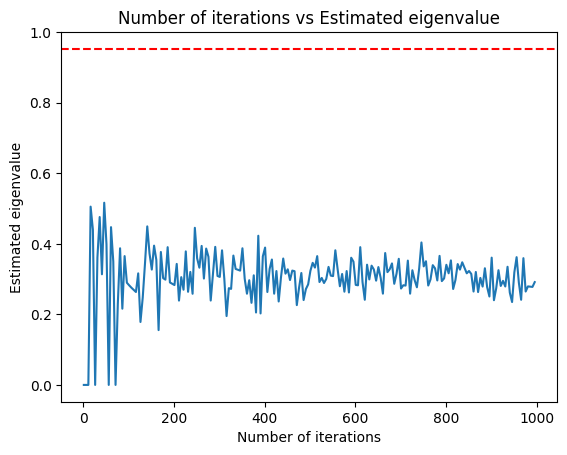

In [16]:
# plot # iterations vs estimation

import matplotlib.pyplot as plt
plt.plot(iterations, estimations)
plt.xlabel('Number of iterations')
plt.ylabel('Estimated eigenvalue')
plt.title('Number of iterations vs Estimated eigenvalue')
# add verical line at exact eigenvalue
exact_result = exact_eigenvalue.eigenvalues[0]
plt.axhline(exact_result, color='r', linestyle='--')
plt.show()



In [35]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import UnitaryGate
import numpy as np
from qiskit_aer import Aer
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.compiler import transpile
from typing import Union, Optional
def iterative_phase_estimation_v2(U: Union[UnitaryGate, np.array], 
                               num_evals: int, 
                               eigenstate: Optional[Union[QuantumCircuit, np.array]],
                               backend,
                               num_qubits=1) -> float:
    
    # Data type management:

    # Convert U to a gate if it's a numpy array
    if isinstance(U, np.ndarray):
        U = UnitaryGate(U)
    
    elif isinstance(U, SparsePauliOp):
        op = Operator(U)
        U = UnitaryGate(op)
    
    elif isinstance(U, Operator):
        U = UnitaryGate(U)

    # Prepare the initial eigenstate
    if isinstance(eigenstate, np.ndarray):
        eigenstate_circuit = QuantumCircuit(num_qubits, name='eigenstate')
        # the eigenstate is a vector of complex numbers that determine the state of the qubits other than the control qubit
        eigenstate_circuit.initialize(eigenstate)

    else:
        eigenstate_circuit = eigenstate

    # Actually create the circuit
    qc = QuantumCircuit(num_qubits + 1,1)
    qc.append(eigenstate_circuit, range(1, num_qubits + 1)) # Apply the eigenstate to the qubits
    qc.h(0) # Apply Hadamard to the control qubit
    u = U.control(1) # Create the controlled-U gate
    qc.append(u, range(num_qubits + 1)) # Apply the controlled-U gate
    qc.h(0) # Apply Hadamard to the control qubit
    qc.measure(0, cbit=0) # Measure the control qubit

    # Execute the circuit num_evals times
    job = backend.run(transpile(qc, backend), dynamic=False, shots=num_evals, memory=True, meas_level=0, meas_return='single')
    num_zeros = 0
    result = job.result()
    counts = result.get_counts()
    print(counts)
    if '0' in counts:
        num_zeros = counts['0']
    tot = sum(counts.values())
    return num_zeros / tot, qc


In [46]:
rand_angle = random.randint(0, 100) % np.pi
print(f"random angle: {rand_angle}")
z_rotation = np.array([[np.exp(1j*rand_angle), 0], [0, np.exp(-1j*rand_angle)]])
z_rotation = UnitaryGate(z_rotation)
exact_eigensolver = NumPyEigensolver()
exact_eigenvalue = exact_eigensolver.compute_eigenvalues(z_rotation)
print(f"rotation matrix: {z_rotation.to_matrix()}")
print(f"exact eigenvalue: {exact_eigenvalue.eigenvalues[0]}")

eigenstate = np.array([1, 0])
iterations = []
estimations = []

for i in range(1, 10000, 10):
    num_evals = i
    print(f'current number of evaluations: {num_evals}')
    p_0, qc = iterative_phase_estimation_v2(z_rotation, num_evals, eigenstate, selected_backend, num_qubits=1)
    print(p_0)
    estimated_eigenvalue = 2 * np.arccos(np.sqrt(p_0))
    iterations.append(i)
    estimations.append(estimated_eigenvalue)
    print(f"estimation: {estimated_eigenvalue} \n exact answer: {exact_eigenvalue.eigenvalues[0]}")


random angle: 2.8938130458959996
rotation matrix: [[-0.96945937+0.24525199j  0.        +0.j        ]
 [ 0.        +0.j         -0.96945937-0.24525199j]]
exact eigenvalue: -0.9694593666699884
current number of evaluations: 1
{'1': 1}
0.0
estimation: 3.141592653589793 
 exact answer: -0.9694593666699884
current number of evaluations: 6
{'1': 6}
0.0
estimation: 3.141592653589793 
 exact answer: -0.9694593666699884
current number of evaluations: 11
{'1': 11}
0.0
estimation: 3.141592653589793 
 exact answer: -0.9694593666699884
current number of evaluations: 16
{'1': 16}
0.0
estimation: 3.141592653589793 
 exact answer: -0.9694593666699884
current number of evaluations: 21
{'1': 21}
0.0
estimation: 3.141592653589793 
 exact answer: -0.9694593666699884
current number of evaluations: 26
{'0': 1, '1': 25}
0.038461538461538464
estimation: 2.746801533890032 
 exact answer: -0.9694593666699884
current number of evaluations: 31
{'1': 31}
0.0
estimation: 3.141592653589793 
 exact answer: -0.9694593

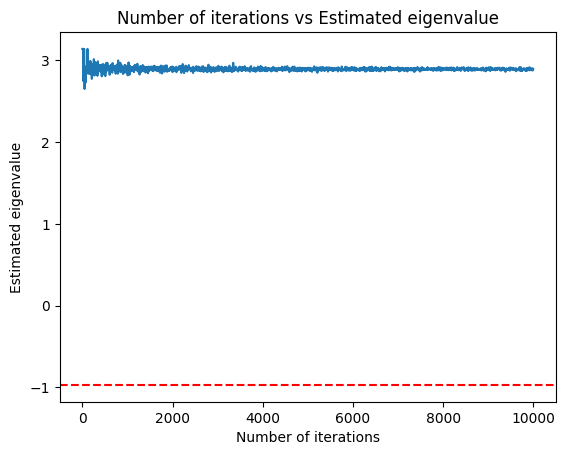

In [47]:
# plot # iterations vs estimation
plt.plot(iterations, estimations)
plt.xlabel('Number of iterations')
plt.ylabel('Estimated eigenvalue')
plt.title('Number of iterations vs Estimated eigenvalue')
# add verical line at exact eigenvalue
exact_result = exact_eigenvalue.eigenvalues[0]
plt.axhline(exact_result, color='r', linestyle='--')
plt.show()